# Fashion-MNIST with convolutional neural network

In this notebook we will build a Convolutional neural networks (CNNs) and train it on the Fashion-MNIST dataset. CNNs are widely used  in computer vision. We will be discussing CNNs in more detail in the Neural Network Architecture section of this notebook.<br>
In this notebook we will be using the keras api to build our cnn. With keras a model can be quickly built.<br>
Before we build the neural network lets get a closer look at the dataset we will be working with as well import the packages which will be used throughout the notebook.

## Packages

Run the cell below to import the packages.

In [1]:
import numpy as np  #The numpy package provides a collection of basic routines for manipulating large arrays and matrices
import idx2numpy    #This package will convert our data from idx3-ubyte format to a numpy array
import PIL          #This package provides image processing capabilities, it will be used to visualize our data
import time         #The time package provides functions to find out the running time of our algorithms

from PIL import Image #Used to save our Image
from matplotlib import pyplot as plt #This function will be used to inconjunction with PIL package to visualize our data

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Dropout
from keras.layers import MaxPooling2D, Dropout
from keras.models import Model, load_model 
from keras.utils  import to_channels_first

from sklearn.metrics import classification_report #To generate the classification report containing precison, recall, f1-score,etc.

Using MXNet backend



## The Data

For this exercise we will be using the Fashion-MNIST dataset. The data was collected by Zolando Research as a replacement for MNIST.[[1]](#1)
<br>
This dataset has pictures of every Zolando's fashion product. There are 60000 images in the "train-images-idx3-ubyte" with the corresponding labels in "train-labels-idx1-ubyte". Each image is a 28x28 8-bit greyscale picture.

We will concatenate the train and test data together, randomly shuffle it and divide it into three sets. The Training set, the dev/cross-validation set and the test set. The training set will consist of 60000 images, the dev set will consist of 5000 images and the test set will have 5000 images.
The reason for doing this is that we can use the dev set to tune our hyperparameters. The test set will be used to give us an unbiased accuracy of our CNN.

In [2]:
#load the training data and labels
X_train = idx2numpy.convert_from_file('data/train-images-idx3-ubyte')
Y_train = idx2numpy.convert_from_file('data/train-labels-idx1-ubyte')

#load the test data and labels
X_test = idx2numpy.convert_from_file('data/t10k-images-idx3-ubyte')
Y_test = idx2numpy.convert_from_file('data/t10k-labels-idx1-ubyte')

#Before we proceed further we will take the first image from the unshuffled X_train and save it to a file.
#We will use this image in the next notebook for visualizing the feature(activation) maps of our network.
img = X_test[0,:,:] #Retrieve the first image from the array and save it to a variable
img = Image.fromarray(img) #Convert it to image using PIL library's image function

img.save("Image_Visualization.jpeg")

In [3]:
#Concatenate the data together
X_shuffled = np.concatenate((X_train,X_test), axis=0)
Y_shuffled = np.concatenate((Y_train,Y_test), axis=0)

#Randomly shuffle the data
permutation = list(np.random.permutation(X_shuffled.shape[0]))
X_shuffled = X_shuffled[permutation,:,:]
Y_shuffled = Y_shuffled[permutation]

In [4]:
#Split the data into train/dev/test
#Train set
X_train = X_shuffled[0:60000,:,:] #Train Data
Y_train = Y_shuffled[0:60000] #Corresponding Labels

X_dev = X_shuffled[60000:65000,:,:] #Dev/cross-validation Data
Y_dev = Y_shuffled[60000:65000] #Corresponding Labels

X_test = X_shuffled[65000:70000,:,:] #Test Data
Y_test = Y_shuffled[65000:] #Corresponding Labels

<br>
<u>Table 1</u> below gives a summary of the data.

![title](Pictures/Fashion-MNIST_visual_table.JPG)

<caption><center> <u>Table_1</u>: Name of classes and example images in our data set. <br> </center></caption>

The cell below will create a list with these label names.

In [5]:
label_names= ["T=Shirt/Top","Trouser","Pullover","Dress","Coat","Sandals","Shirt","Sneaker","Bag","Ankle boots"]

<br>
With the code below we can inspect the individual images in the training dataset. Note: To view images in other datasets(dev/test) replace X_train and Y_train in the code below with the array for those datasets.

Image belongs to class: 8
It is a: Bag


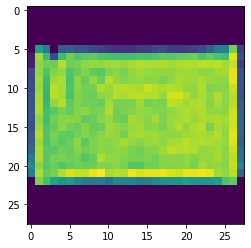

In [6]:
index = 0 #Change this to get a different image, python indexes from 0 therefore the index for our dataset will be from 0-59999

image = X_train[index] #The image we want
plt.imshow(image) #Display the image

print("Image belongs to class: "+str((Y_train[index])))
print("It is a: "+label_names[Y_train[index]])

<br>
First Lets convert our input feature matrices <b>X_train</b>, <b>X_dev</b> and <b>X_test</b> to (number of examples,28,28,1) as this is the shape of the input that keras expects. Lets also have a look at the shape of our dataset.

In [7]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
X_dev = X_dev.reshape(X_dev.shape[0],X_dev.shape[1],X_dev.shape[2],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)

In [8]:
print("The Shape of training data is:",X_train.shape)
print("The Shape of training labels is:",Y_train.shape)

print("The Shape of dev data is:",X_dev.shape)
print("The Shape of dev labels is:",Y_dev.shape)

print("The Shape of test data is:",X_test.shape)
print("The Shape of test labels is:",Y_test.shape)

The Shape of training data is: (60000, 28, 28, 1)
The Shape of training labels is: (60000,)
The Shape of dev data is: (5000, 28, 28, 1)
The Shape of dev labels is: (5000,)
The Shape of test data is: (5000, 28, 28, 1)
The Shape of test labels is: (5000,)


</br><b>Y_train</b>,<b>Y_dev</b> and <b>Y_test</b> are (60000,), (5000,) and (5000,) arrays. For our neural network we will convert them to (60000,10) arrays (one hot encoding).</br>
The code below will carry out this operation.

In [9]:
classes = 10               #Number of classes for our dataset
Y_train = np.eye(classes)[Y_train.reshape(-1)] #One hot encode Y_train
Y_dev = np.eye(classes)[Y_dev.reshape(-1)] #One hot encode Y_dev
Y_test = np.eye(classes)[Y_test.reshape(-1)] #One hot encode Y_test

In [10]:
print(Y_train.shape)
print(Y_dev.shape)
print(Y_test.shape)

(60000, 10)
(5000, 10)
(5000, 10)


The output matches our expectation. Lets move on.


## Standardizing the input

We will standardize our input feature matrices <b>X_train</b>, <b>X_dev</b> and <b>X_test</b>. This will help our algorithm converge faster. Generally we standardize the data by subtracting the mean of input matrix from each value in it and dividing by the standard deviation of of the matrix, but for image data dividing each value of the input matrix with 255(max value of a pixel) works as well.

In [11]:
X_train = X_train/255 #Normalize the matrix
X_dev = X_dev/255
X_test = X_test/255

Our data is processed and we are ready to feed it to our network.

## The neural network architecture

The decision to use convolutional neural networks is based on the following:- <br>
A MLP has no built-in invariance with respect to translations and local distortions of the input. Our neural network should classify a shirt as a shirt if it is translated by some units. <br>
The sparsity of connections in CNN lowers the numbers of trainable parameters therefore making it computational feasible to train the network compared to a MLP for which the the number of trainable parameters will be very high if the image resolution is high. The large number of parameters also means that we would need a large amount of data if the network is not to overfit.[[2]](#b)<br>

The CNN model used in this notebook is inspired from VGG-16.[[3]](#c)

In [12]:
def model_conv(input_shape):
    
    X_input = Input(input_shape)

    #Convolution->BatchNorm->ReLUx3
    X = Conv2D(8, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', bias_initializer='zeros', name='Block1_conv1a')(X_input)
    X = BatchNormalization(axis=1, name='Block1_bn1a')(X)
    X = Activation('relu')(X)
    X = Conv2D(8, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', bias_initializer='zeros', name='Block1_conv1b')(X)
    X = BatchNormalization(axis=1, name='Block1_bn1b')(X)
    X = Activation('relu')(X)
    X = Conv2D(8, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', bias_initializer='zeros', name='Block1_conv1c')(X)
    X = BatchNormalization(axis=1, name='Block_bn1c')(X)
    X = Activation('relu')(X)
    #MaxPool
    X = MaxPooling2D((2,2), name='Block1_maxpool')(X)
    X = Dropout(0.1)(X)
    
    #Convolution->BatchNorm->ReLUx3
    X = Conv2D(16, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', bias_initializer='ones', name='Block2_conv2a')(X)
    X = BatchNormalization(axis=1, name='Block2_bn2a')(X)
    X = Activation('relu')(X)
    X = Conv2D(16, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', bias_initializer='ones', name='Block2_conv2b')(X)
    X = BatchNormalization(axis=1, name='Block2_bn2b')(X)
    X = Activation('relu')(X)
    X = Conv2D(16, (3,3), strides=(1,1), padding='same', kernel_initializer='he_normal', bias_initializer='ones', name='Block2_conv2c')(X)
    X = BatchNormalization(axis=1, name='Block2_bn2c')(X)
    X = Activation('relu')(X)
    #MaxPool
    X = MaxPooling2D((2,2), name='Block2_maxpool')(X)

    #Flatten X(convert it to a vector) and feed it to fully connected layers
    X = Flatten()(X)
    X = Dropout(0.5)(X)
    X = Dense(128, activation='relu', kernel_initializer='he_normal', bias_initializer='zeros', name='fc1')(X)
    X = Dropout(0.3)(X)
    X = Dense(10, activation='softmax', name='softmax')(X)

    # Create model. This creates our Keras model instance, we'll use this instance to train/test the model.
    model = Model(inputs=X_input, outputs=X, name='model_conv')
    
    return model

The backend used for Keras is Mxnet. Mxnet expects the input to be channels first. We will convert this in the cell below.

In [13]:
X_train = to_channels_first(X_train)
print(X_train.shape)

(60000, 1, 28, 28)


In [14]:
model = model_conv(X_train.shape[1:])

We will be using the keras' default learning rate for ADAM. However this is probably the most important hyperparameter. If we want to tune the model this should be the first thing we should tweak.

In [15]:
model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["accuracy"])

The cell below will print the summary of our model.

In [16]:
model.summary() #Shows the summary of our model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1, 28, 28)         0         
_________________________________________________________________
Block1_conv1a (Conv2D)       (None, 8, 28, 28)         80        
_________________________________________________________________
Block1_bn1a (BatchNormalizat (None, 8, 28, 28)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 8, 28, 28)         0         
_________________________________________________________________
Block1_conv1b (Conv2D)       (None, 8, 28, 28)         584       
_________________________________________________________________
Block1_bn1b (BatchNormalizat (None, 8, 28, 28)         32        
_________________________________________________________________
activation_2 (Activation)    (None, 8, 28, 28)         0         
__________

As we can see from the summary above the fully connected layer has the highest number of parameters.

<br>Time to train the model the cell below will start training the network!

In [17]:
model.fit(x=X_train, y=Y_train, epochs= 20, batch_size=64, shuffle=True)

Epoch 1/20
   64/60000 [..............................] - ETA: 2:55 - loss: 4.7469 - acc: 0.0469

c:\python\lib\site-packages\mxnet\module\bucketing_module.py:411: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  force_init=force_init)


60000/60000 [==============================] - 197s 3ms/step - loss: 0.7131 - acc: 0.7392
Epoch 2/20
60000/60000 [==============================] - 196s 3ms/step - loss: 0.4443 - acc: 0.8338
Epoch 3/20
60000/60000 [==============================] - 197s 3ms/step - loss: 0.3872 - acc: 0.8567
Epoch 4/20
60000/60000 [==============================] - 196s 3ms/step - loss: 0.3535 - acc: 0.8691
Epoch 5/20
60000/60000 [==============================] - 197s 3ms/step - loss: 0.3267 - acc: 0.8815
Epoch 6/20
60000/60000 [==============================] - 196s 3ms/step - loss: 0.3127 - acc: 0.8852
Epoch 7/20
60000/60000 [==============================] - 197s 3ms/step - loss: 0.3019 - acc: 0.8904
Epoch 8/20
60000/60000 [==============================] - 196s 3ms/step - loss: 0.2885 - acc: 0.8943
Epoch 9/20
60000/60000 [==============================] - 196s 3ms/step - loss: 0.2826 - acc: 0.8954
Epoch 10/20
60000/60000 [==============================] - 196s 3ms/step - loss: 0.2740 - acc: 0.9000


Instead of training the model again to make predictions in the future, we are going to save our model.

In [18]:
model.save('Fashion_MNIST_Conv.h5')

<br> Let's see the classification report for the training set.

In [19]:
predictions_train = model.predict(X_train) #Generate predictions for the training data

predictions_train = np.argmax(predictions_train, axis = 1) #Index of the max value in the rows of prediction matrix
labels_train = np.argmax(Y_train, axis = 1) #Index of the max value in the rows of label matrix

print(classification_report(predictions_train,labels_train))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90      5980
           1       0.99      1.00      0.99      5967
           2       0.89      0.92      0.91      5756
           3       0.96      0.92      0.94      6278
           4       0.92      0.87      0.89      6332
           5       0.99      0.99      0.99      5961
           6       0.80      0.84      0.82      5713
           7       0.99      0.96      0.98      6154
           8       0.99      0.99      0.99      5977
           9       0.97      0.99      0.98      5882

    accuracy                           0.94     60000
   macro avg       0.94      0.94      0.94     60000
weighted avg       0.94      0.94      0.94     60000



<br>The cells below evaluates the model on the dev set

In [20]:
X_dev = to_channels_first(X_dev)

In [21]:
predictions_dev = model.predict(X_dev)

predictions_dev = np.argmax(predictions_dev, axis = 1)
labels_dev = np.argmax(Y_dev, axis = 1)

print(classification_report(predictions_dev,labels_dev))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       454
           1       0.99      0.99      0.99       516
           2       0.88      0.91      0.89       486
           3       0.95      0.90      0.93       549
           4       0.92      0.83      0.87       551
           5       0.99      0.99      0.99       490
           6       0.74      0.82      0.78       471
           7       0.99      0.93      0.96       513
           8       0.99      0.99      0.99       496
           9       0.94      0.99      0.96       474

    accuracy                           0.92      5000
   macro avg       0.92      0.92      0.92      5000
weighted avg       0.93      0.92      0.92      5000



Dev-Set accuracy is  approximately same as training accuracy. The model is slightly overfitting. If we tune the hyperparameters e.g learning rate, number of layers, number of hidden units in fully connected layers and number of channels and filter sizes in convolutional layers, minibatch size, learning rate decay, etc. we might get even better accuracy<br>

The model does not perform as well on class 6. Further analysis is required as to why this is the case.

<br>We should now see how our model performs on the test set.The cell below will generate the predictions.

In [22]:
X_test = to_channels_first(X_test)

In [23]:
predictions_test = model.predict(X_test) #Generate predictions for the training data

predictions_test = np.argmax(predictions_test, axis = 1) #Index of the max value in the rows of prediction matrix
labels_test = np.argmax(Y_test, axis = 1) #Index of the max value in the rows of label matrix

print(classification_report(predictions_test,labels_test))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88       468
           1       0.99      1.00      0.99       487
           2       0.86      0.91      0.89       470
           3       0.96      0.91      0.93       520
           4       0.93      0.85      0.89       547
           5       0.98      0.99      0.99       501
           6       0.76      0.82      0.79       470
           7       0.98      0.96      0.97       531
           8       0.99      0.98      0.98       513
           9       0.97      0.98      0.97       493

    accuracy                           0.93      5000
   macro avg       0.93      0.93      0.93      5000
weighted avg       0.93      0.93      0.93      5000



The model performs decently. Test-set results are pretty close to the dev-set results.

<br> The code below will display an image from the test set, it's true class as well as the class that our algorithm has predicted.

True class of image is: 0
Which is a: T=Shirt/Top

The NN predicts that this image belongs to class: 0
Which is a: T=Shirt/Top


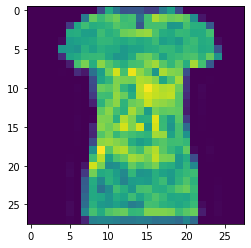

In [24]:
X_test = X_test.reshape(5000,28,28)

index = 0
image = X_test[index,:,:]
plt.imshow(image)
print("True class of image is: "+str(np.argmax(Y_test[index])))
print("Which is a: "+label_names[np.argmax(Y_test[index])])

print("\nThe NN predicts that this image belongs to class: "+str(predictions_test[index]))
print("Which is a: "+label_names[(predictions_test[index])])

## Conclusion

The network we trained provides decent results however it can be improved if we tune the hyperparamters. Secondly if we have a measure of how accurately humans predict the images in this dataset we can use it as a proxy for Bayes-error. This will give us an idea of how much the model can be improved.<br>
Our Convolutional neural network provides better results than the MLP we trained in the previous notebook.<br>
In the next notebook we will visualize the filters and feature maps of the same network we trained here.


## References

<a id="1"></a>1. H. Xiao, K. Rasul, R. Vollgraf. Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. *arXiv preprint arXiv:1708.07747 [cs.LG]*, 2017.
<br>
<a id="b"></a>2. Y. Lecun, L. Bottou, Y. Bengio, P. Haffner, "Gradient-based learning applied to document recognition", Proc. IEEE, vol. 86, no. 11, pp. 2278-2324, 1998.
<br>
<a id="c"></a>3. K. Simonyan, A. Zisserman. Very Deep Convolutional Networks for Large-Scale Image Recognition. *arXiv preprint arXiv:1409.1556v6 [cs.CV]*, 2015.
<br>
4. Krizhevsky, Alex, Sutskever, Ilya, and Hinton, Geoffrey E.  Imagenet classification with deep convolutional neural networks. In Advances in neural information processing systems, pp. 1097–1105, 2012.
<br>
5. K. He, X. Zhang, S. Ren, J. Sun. Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification. *arXiv preprint arXiv:1502.01852 [cs.CV]*, 2015.
<br>
6. Srivastava, Nitish & Hinton, Geoffrey & Krizhevsky, Alex & Sutskever, Ilya & Salakhutdinov, Ruslan. (2014). Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Journal of Machine Learning Research. 15. 1929-1958.
<br>
7. D. P. Kingma, J. Ba. Adam: A Method for Stochastic Optimization. *arXiv preprint arXiv:1412.6980v9 [cs.LG]*, 2017.
<br>